In [1]:
import os
import re
import ast
import math
import time
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style

from glob import glob
from PIL import Image, ImageDraw 
from tqdm import tqdm
from dask import bag

import tensorflow as tf
import tensorflow.keras as K
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
from tensorflow.keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D 
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten, Activation

warnings.filterwarnings('ignore') # to suppress some matplotlib deprecation warnings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Reshape, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.initializers import RandomNormal
from keras.backend import clear_session
np.random.seed(0)

Using TensorFlow backend.


In [12]:
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
label = "swan"

input_csv_file = 'drive/My Drive/input/train/swan.csv'

dir_to_save_model = "drive/My Drive/Colab Notebooks/gan/"+label+"/"

num_examples = 100

In [0]:
imheight, imwidth = 64, 64
ims_per_class = 200000
width = 5

def draw_it_(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width = width)
    image = image.resize((imheight, imwidth))
    return np.array(image)/-127.5 + 1

In [37]:
train = pd.read_csv(input_csv_file, nrows=ims_per_class)
imagebag = bag.from_sequence(train.drawing.values).map(draw_it_) 
trainarray = np.array(imagebag.compute())
print(trainarray.shape)
X_train = trainarray.reshape(trainarray.shape[0], imheight, imwidth, 1)
print(X_train.shape)


(119694, 64, 64)
(119694, 64, 64, 1)


[[[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [ 1.]
  [ 1.]
  [-1.]]

 ...

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]

 [[-1.]
  [-1.]
  [-1.]
  ...
  [-1.]
  [-1.]
  [-1.]]]


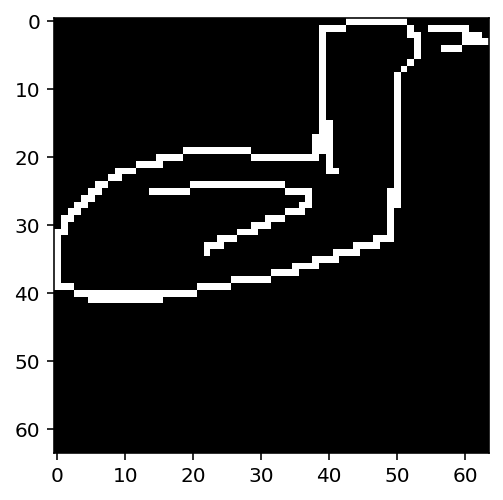

In [38]:
print(X_train[80])
a = X_train[80].reshape(imheight, imwidth)
plt.imshow(a, cmap='gray')


In [0]:
class DCGAN():
  
  def __init__(self):
      self.img_rows = imheight
      self.img_cols = imwidth
      self.img_shape = (self.img_rows, self.img_cols, 1)

      self.latent_dim = 100

      self.optimizer = Adam(0.0002, 0.5)

      self.discriminator = self.load_discriminator()
      self.discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
      self.discriminator.summary()

      self.generator = self.load_generator()
      self.generator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
      self.generator.summary()

      self.gan = self.build_GAN()
  
  def build_GAN(self):

      self.discriminator.trainable = False
      gan_input = Input(shape=(self.latent_dim,))
      img = self.generator(gan_input)
      
      gan_output = self.discriminator(img)
      gan = Model(gan_input, gan_output, name='GAN')
      gan.compile(loss='binary_crossentropy', optimizer=self.optimizer)
      gan.summary()
      
      return gan
    
  def load_generator(self):

      G = Sequential()
      G.add(Dense(128 * 8 * 8, activation="relu", input_dim=self.latent_dim))
      G.add(Reshape((8, 8, 128)))
      G.add(BatchNormalization(momentum=0.8))
      
      G.add(UpSampling2D())
      G.add(Conv2D(128, kernel_size=3, padding="same"))
      G.add(LeakyReLU(0.2))
      G.add(BatchNormalization(momentum=0.8))
      
      G.add(UpSampling2D())
      G.add(Conv2D(64, kernel_size=3, padding="same"))
      G.add(LeakyReLU(0.2))
      G.add(BatchNormalization(momentum=0.8))

      G.add(UpSampling2D())
      G.add(Conv2D(32, kernel_size=3, padding="same"))
      G.add(LeakyReLU(0.2))
      G.add(BatchNormalization(momentum=0.8))

      G.add(Conv2D(1, kernel_size=3, padding='same', activation = "tanh"))
      #G.summary()
      

      noise = Input(shape=(self.latent_dim,))
      img = G(noise)
      print(img.shape)

      return Model(noise, img, name='Generator')

  def load_discriminator(self):
 
      D = Sequential()
      D.add(Flatten())
      D.add(Dense(1024, kernel_initializer=RandomNormal(stddev=0.02)))
      D.add(LeakyReLU(0.2))
      D.add(Dropout(0.3))
      D.add(Dense(512))
      D.add(LeakyReLU(0.2))
      D.add(Dropout(0.3))
      D.add(Dense(256))
      D.add(LeakyReLU(0.2))
      D.add(Dropout(0.3))
      D.add(Dense(1, activation='sigmoid'))

      img = Input(shape=self.img_shape)
      validity = D(img)

      return Model(img, validity, name='Discriminator')
 

  def train(self, X_train, epochs, batch_size=128, sample_interval=50):

      real = np.ones((batch_size, 1))
      fake = np.zeros((batch_size, 1))

      avg_losses = {'D': [], 'G': []}
      num_batches = len(X_train) // batch_size
      print(num_batches)
      
      for epoch in range(epochs):
          start_time = time.time()
          d_loss_acc = 0
          g_loss_acc = 0
          for i in range(num_batches):
            
            imgs = X_train[np.random.randint(0, len(X_train) - 1, batch_size)]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            self.discriminator.trainable = True

            d_loss_real = self.discriminator.train_on_batch(imgs, real * (np.random.uniform(0.7, 1.2)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake + (np.random.uniform(0.0, 0.3)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            self.discriminator.trainable = False
            
            g_loss = self.gan.train_on_batch(noise, real)            
            
            d_loss_acc += d_loss
            g_loss_acc += g_loss

          if (epoch + 1) % sample_interval == 0 or epoch == 0:
              self.sample_images(epoch)
              self.savemodel(epoch)

          avg_losses['D'].append(d_loss_acc/num_batches)
          avg_losses['G'].append(g_loss_acc/num_batches)
      
          end_time = time.time()  
          print("It cost : ", end_time - start_time)
      
      self.plot_loss(avg_losses)


  def sample_images(self, epoch):
    
    random_noise = np.random.normal(0, 1, size=[num_examples, self.latent_dim])
    generated_images = self.generator.predict(random_noise)
    generated_images = generated_images.reshape(num_examples,imheight, imwidth)


    correct = 0

    for i in range(generated_images.shape[0]):
        
        
        plt.subplot(10, 10, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')

        grapharray = generated_images[i]


        for j in range(64):
            for k in range(64):
                if grapharray[j][k] < 0.2 : grapharray[j][k] = 1
                else: grapharray[j][k] = 0

        grapharray = np.reshape(grapharray, (1,64, 64, 1))
            
    
    plt.suptitle("Samples from G - Epoch = " + str(epoch+1))
    plt.show()

  def plot_loss(self, losses):
     
      plt.figure(figsize=(10, 8))
      plt.plot(losses["D"], label="Discriminator loss")
      plt.plot(losses["G"], label="Generator loss")
   
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.title("Loss History")
      plt.show()

  def savemodel(self, epoch):
      self.generator.save(dir_to_save_model + label + str(epoch+1) + ".h5")

In [40]:
gan = DCGAN()
gan.train(X_train, epochs=50, batch_size=128, sample_interval=5)

Output hidden; open in https://colab.research.google.com to view.